In [6]:
# import packages
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import foldnorm
from uncertainty_toolbox import metrics_calibration


# fix numpy seed for reproducibility


### Generates the toy model

In [7]:
import torch

def NLL(input: torch.Tensor, target: torch.Tensor, var: torch.Tensor, full=True, eps=1e-06):
    return torch.nn.functional.gaussian_nll_loss(input.flatten(), target.flatten(), var.flatten(), full=full,eps=eps)

def RMSE(input, target):
    return torch.sqrt(torch.mean((input.flatten() - target.flatten())**2))

def MSE(input, target):
    return torch.mean((input.flatten() - target.flatten())**2)

def get_coeff(input: torch.Tensor, target: torch.Tensor, var: torch.Tensor) -> torch.tensor:
    """ Returns dimensionless NLL coefficient
    """
    #print(input.shape)
    #print(target.shape)
    #print(var.shape)
    
    mse = MSE(input,target)
    uncertainty_estimate = (input.flatten() - target.flatten())**2
    
    LL_best = torch.nn.functional.gaussian_nll_loss(input.flatten(), target.flatten(), uncertainty_estimate.flatten(), full=False, eps=0.)
    
    LL_worst_case_best_RMSE = torch.nn.functional.gaussian_nll_loss\
        (input.flatten(), target.flatten(), torch.ones_like(var.flatten())*mse, full=False, eps=0.)
    
    LL_actual = torch.nn.functional.gaussian_nll_loss(input.flatten(), target.flatten(), var.flatten(), full=False, eps=0.)
    
    coeff = 1/( LL_best - LL_worst_case_best_RMSE) * (LL_actual - LL_worst_case_best_RMSE) * 100

    return coeff

In [8]:
def get_z_score_variance(input: torch.tensor, target: torch.tensor, var_pred: torch.tensor):

    z = (target.flatten() - input.flatten()) / torch.sqrt(var_pred.flatten())

    return torch.var(z)

In [9]:
import matplotlib.pyplot as plt
import matplotlib

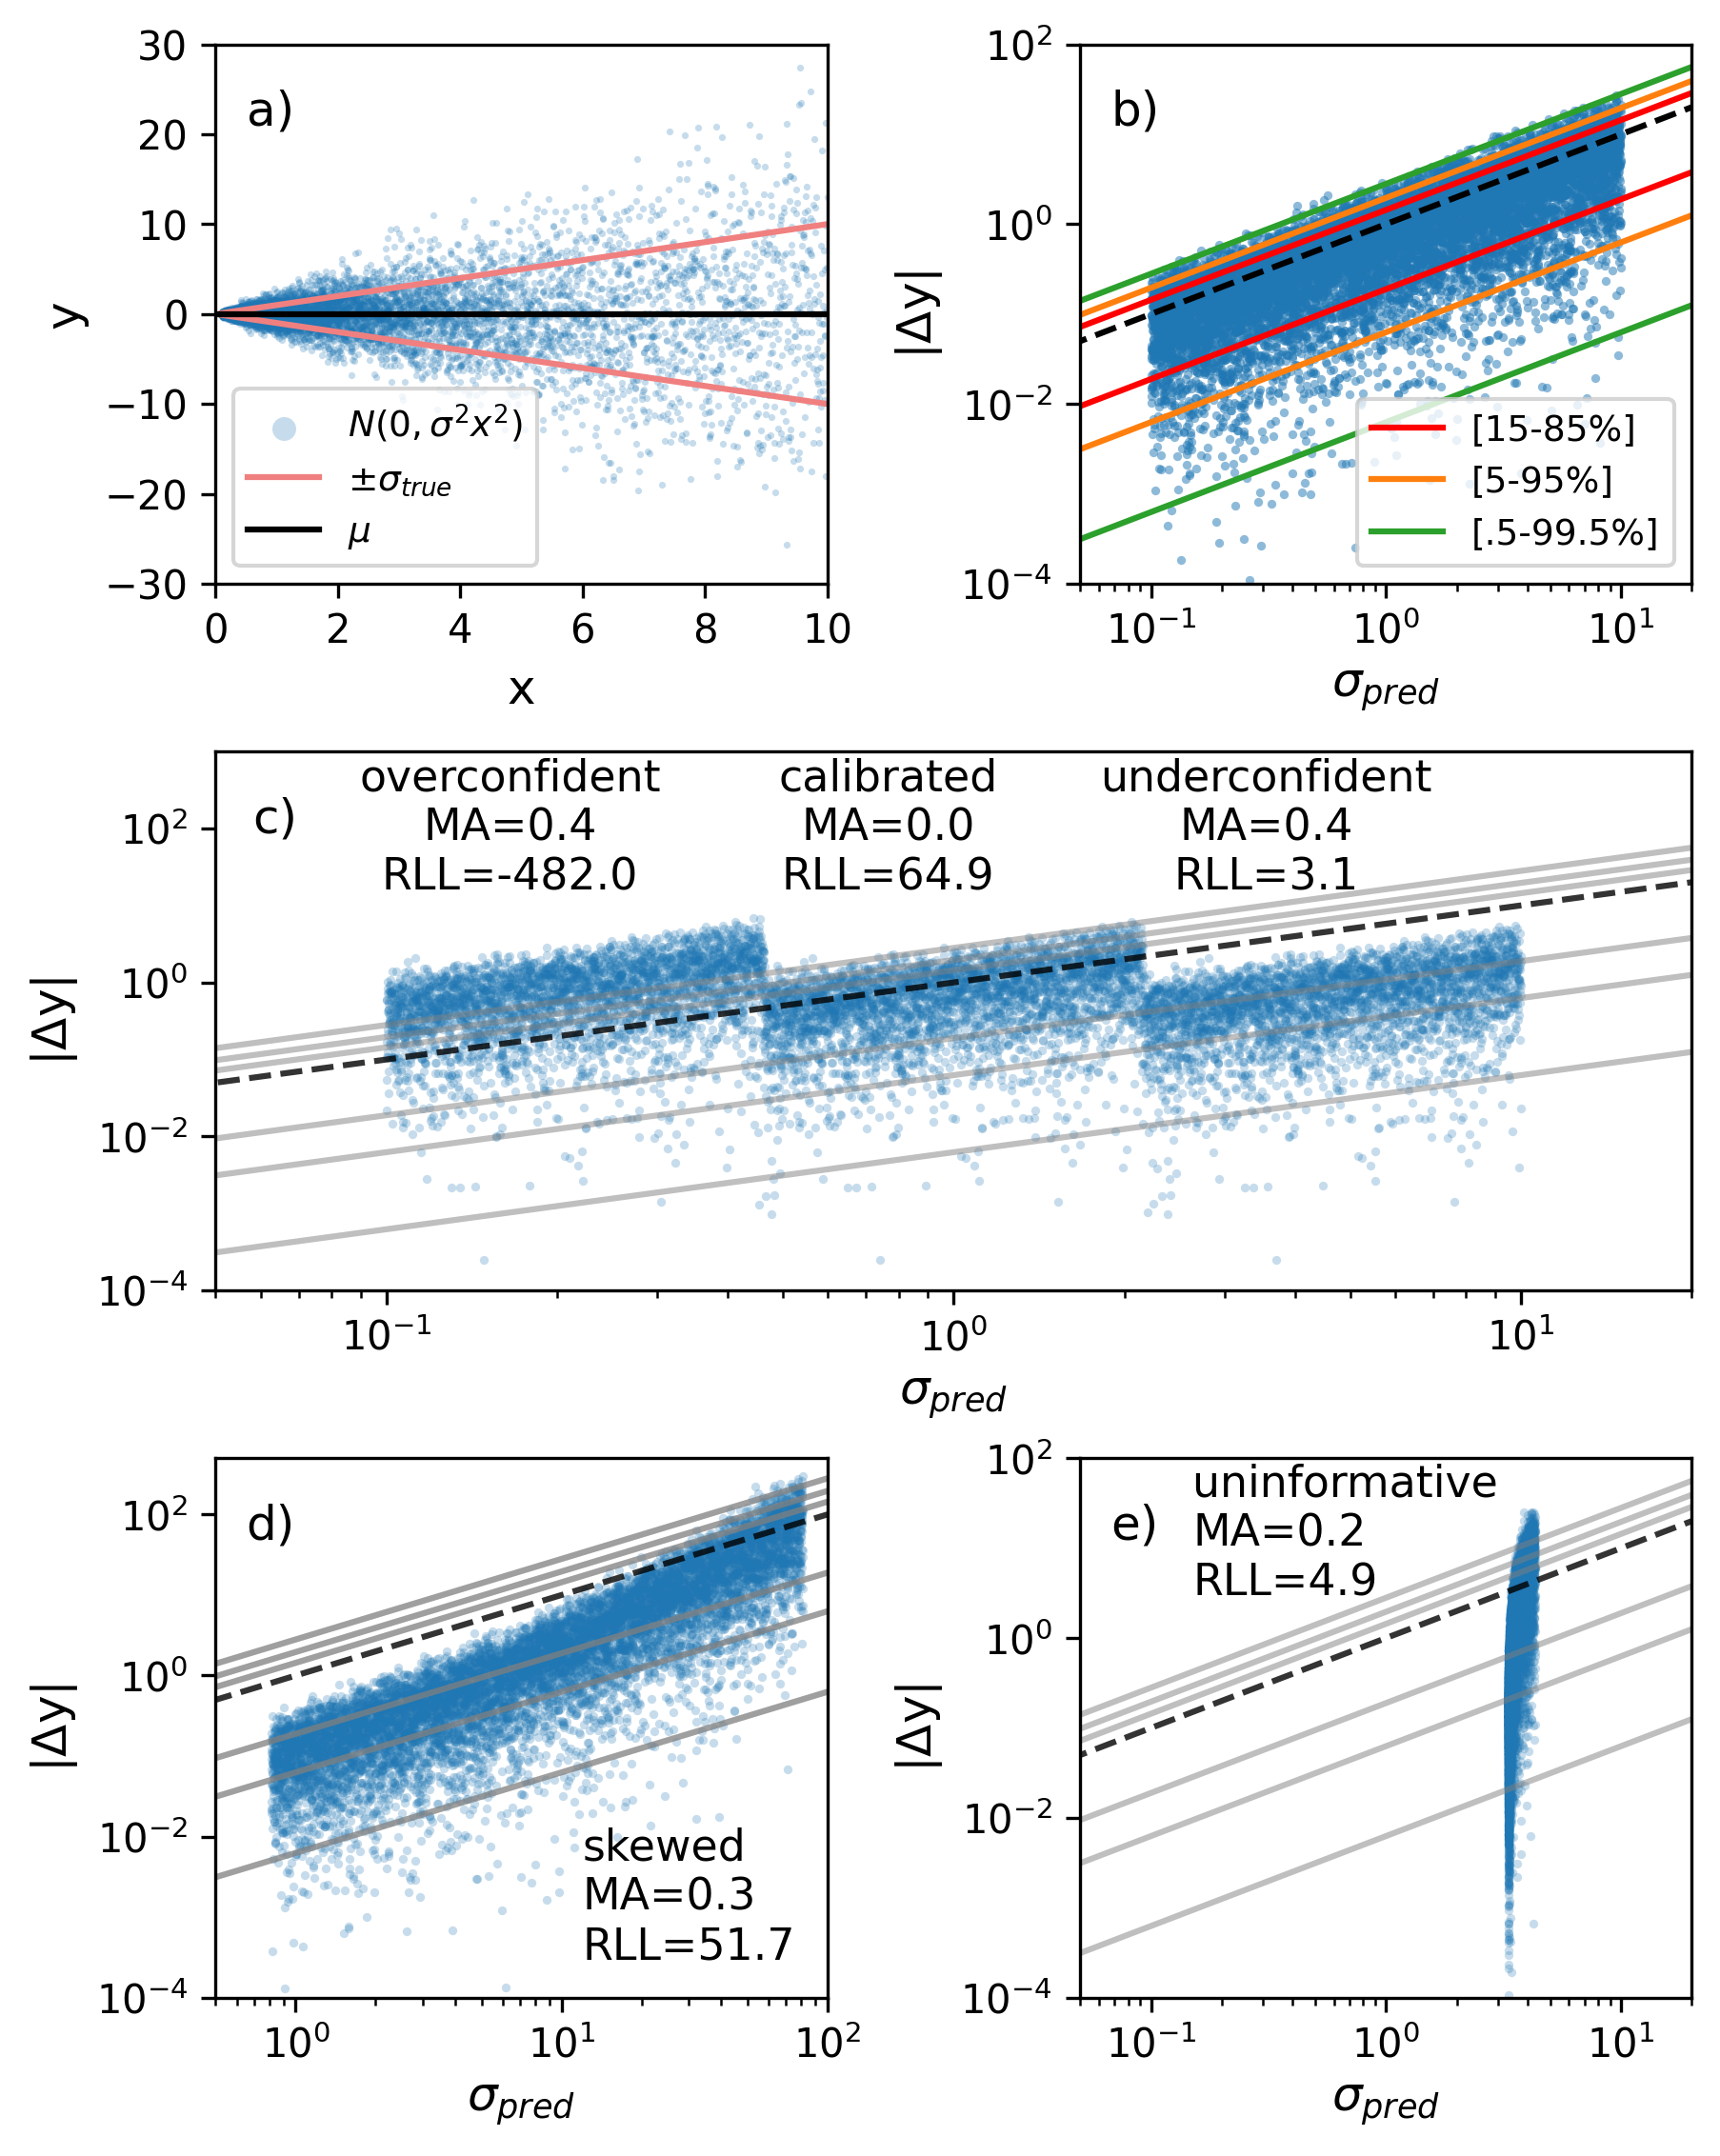

In [10]:
ROUND_DIGITS = 1
plt.rcParams.update({'font.size': 11.0})
matplotlib.rc('xtick', labelsize=10.0) 
matplotlib.rc('ytick', labelsize=10.0) 
plt.rc('axes', labelsize=12.)

QUANTILE_ALPHA = 0.5
QUANTILE_ALPHA_UNIT = 0.8
SCATTER_ALPHA = 0.25

POINTS =10000
np.random.seed(0)

#generate the grid points
x = np.logspace(-1.,1,POINTS)
y = np.zeros(POINTS)

#generate the noise/targets
#noise level is the perfect uncertainty estimate 

noise_level = np.abs(x) * 1
noise_hetero = np.random.normal(y,noise_level,POINTS) 

#generate residuals
z = np.abs(y-(y+noise_hetero))



#generate the quantile lines by evaluating the folded normal distribution
# quantile distribution

x_2 = np.logspace(-5.,5.,10)
noise_level_2 = np.abs(x_2)
quantiles_lower_01 = [foldnorm.ppf(0.15, 0.,0.,i) for i in noise_level_2]
quantiles_upper_01 = [foldnorm.ppf(0.85, 0.,0.,i) for i in noise_level_2]
quantiles_lower_05 = [foldnorm.ppf(0.05, 0.,0.,i) for i in noise_level_2]
quantiles_upper_05 = [foldnorm.ppf(0.95, 0.,0.,i) for i in noise_level_2]
quantiles_lower_005 = [foldnorm.ppf(0.005, 0.,0.,i) for i in noise_level_2]
quantiles_upper_005 = [foldnorm.ppf(0.995, 0.,0.,i) for i in noise_level_2]

fig = plt.figure(figsize=(9.0, 7.5), dpi=300)
spec = fig.add_gridspec(3, 3)


ax0 = fig.add_subplot(spec[1, :2])
ax10 = fig.add_subplot(spec[2, 0])
ax11 = fig.add_subplot(spec[2, 1])

axtoy = fig.add_subplot(spec[0, 0])
axexplain = fig.add_subplot(spec[0, 1])

axtoy.scatter(x,y+noise_hetero,s=3., alpha=SCATTER_ALPHA, rasterized=True, linewidth=0. )
axtoy.scatter([],[],label=r"$N(0,\sigma^2 x^2)$", alpha=SCATTER_ALPHA, linewidth=0., color="tab:blue" )
axtoy.plot(x,y+noise_level, color="lightcoral", label=r"$\pm \sigma_{true}$", rasterized=True)
#plt.plot(x,y+1/alpha*noise_level, color="tab:red", label=r"$\sigma_{pred}$")
axtoy.plot(x,y-noise_level, color="lightcoral", rasterized=True)
#plt.plot(x,y-1/alpha*noise_level, color="tab:red",)
axtoy.axhline(0,  color="black", label=r"$\mu$", rasterized=True)
axtoy.text(0.05, 0.85, "a)", fontsize=12, transform=axtoy.transAxes, rasterized=True)
axtoy.legend(loc="lower left",fontsize=9.)
axtoy.set_ylim(-30,30)
axtoy.set_xlim(0,10)
axtoy.set_xlabel("x")
axtoy.set_ylabel("y")









axexplain.scatter(noise_level, z, s=5., color="tab:blue", alpha=0.5, rasterized=True, linewidth=0.)

axexplain.plot(noise_level_2, quantiles_upper_01, color = "red", label="[15-85%]", alpha=QUANTILE_ALPHA*2, rasterized=True)
axexplain.plot(noise_level_2, quantiles_lower_01, color = "red", alpha=QUANTILE_ALPHA*2, rasterized=True)

axexplain.plot(noise_level_2, quantiles_lower_05, color = "tab:orange", label="[5-95%]", alpha=QUANTILE_ALPHA*2, rasterized=True)
axexplain.plot(noise_level_2, quantiles_upper_05, color = "tab:orange", alpha=QUANTILE_ALPHA*2, rasterized=True)

axexplain.plot(noise_level_2, quantiles_lower_005, color = "tab:green", label="[.5-99.5%]", alpha=QUANTILE_ALPHA*2, rasterized=True)
axexplain.plot(noise_level_2, quantiles_upper_005, color = "tab:green", alpha=QUANTILE_ALPHA*2, rasterized=True)

axexplain.plot(np.logspace(-5.5,5.5), np.logspace(-5.5,5.5),color="black",linestyle="--", rasterized=True)


axexplain.loglog()
axexplain.set_xlim(0.05,20)
axexplain.set_ylim(1e-04,1e02)
axexplain.set_ylabel(r"|$\Delta$y|")
axexplain.set_xlabel(r"$\sigma_{pred}$")
axexplain.legend(fontsize=9.)
axexplain.text(0.05, 0.85, "b)", fontsize=12, transform=axexplain.transAxes, rasterized=True)





for a_i, interval, title in zip([5.,1,1/5.,], [(10**(1/3),10**1), (10**-(1/3),10**(1/3)), (10**-1, 10**-(1/3)),],["underconfident","calibrated","overconfident"]):
    tmp_noise = np.copy(noise_level)*a_i
    #only plot point within the range 1e-1 and 1e-2/3
    tmp_noise_sel = (tmp_noise > interval[0]) & (tmp_noise < interval[1])
    
    if a_i != 1:
        ax0.scatter(tmp_noise[tmp_noise_sel], z[tmp_noise_sel], s=5., color="tab:blue", alpha=SCATTER_ALPHA, rasterized=True, linewidth=0.)
    else:
        ax0.scatter(tmp_noise[tmp_noise_sel] , z[tmp_noise_sel], s=5., color="tab:blue", alpha=SCATTER_ALPHA, rasterized=True, linewidth=0.)
    
    #text in the upper left corner with miscalibration area
    
    MA = metrics_calibration.miscalibration_area(y, noise_level*a_i,(y+noise_hetero))
    
    SNLL = get_coeff( torch.tensor(y),\
                    torch.tensor(y+noise_hetero),\
                    torch.tensor(tmp_noise)**2)

    

    ax0.text(interval[0]*1.65, 100, title + "\n" + \
             f"MA={round(MA,ndigits=ROUND_DIGITS)}"\
             + "\n" +f"RLL={round(float(SNLL),ndigits=ROUND_DIGITS)}",\
            
            horizontalalignment='center',
            verticalalignment='center',)

    #print("z score variance cal: {}".format(get_z_score_variance(torch.tensor(y),\
    #                torch.tensor(y+noise_hetero),\
    #                torch.tensor(tmp_noise)**2)))
    # + "\n" +f"sharpness={round(sharpness,ndigits=3)}",\

ax0.plot(noise_level_2, quantiles_upper_01, color = "grey", label="quartile=[0.15,0.85]", alpha=QUANTILE_ALPHA, rasterized=True)
ax0.plot(noise_level_2, quantiles_lower_01, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax0.plot(noise_level_2, quantiles_lower_05, color = "grey", label="quartile=[0.05,0.95]", alpha=QUANTILE_ALPHA, rasterized=True)
ax0.plot(noise_level_2, quantiles_upper_05, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax0.plot(noise_level_2, quantiles_lower_005, color = "grey", label="quartile=[0.005,0.995]", alpha=QUANTILE_ALPHA, rasterized=True)
ax0.plot(noise_level_2, quantiles_upper_005, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax0.plot(np.logspace(-5.5,5.5), np.logspace(-5.5,5.5),color="black",linestyle="--", alpha=QUANTILE_ALPHA_UNIT, rasterized=True)
ax0.loglog()

ax0.set_xlim(0.05,20)
ax0.set_ylim(1e-04,1e03)

ax0.set_ylabel(r"|$\Delta$y|")
ax0.set_xlabel(r"$\sigma_{pred}$")
ax0.text(0.025, 0.85, "c)", fontsize=12, transform=ax0.transAxes, rasterized=True)


# now make skewed plots (bia changing the noise level):
alpha=0.5

#introduce weights such that the

noise_level_skewed = np.abs(x) ** (2) + np.abs(x)
noise_hetero_skewed = np.random.normal(y,noise_level_skewed,POINTS) 

z_skewed = np.abs(y-(y+noise_hetero_skewed))
#generate residuals

#globally calibrate uncertainties:
alpha_cal = np.sqrt(np.mean(z_skewed**2)/np.mean(noise_level**2))

ax10.scatter(noise_level*alpha_cal, z_skewed, s=5., color="tab:blue", alpha=SCATTER_ALPHA, rasterized=True, linewidth=0.)
ax10.plot(noise_level_2, quantiles_upper_01, color = "grey", label="quartile=[0.15,0.85]", alpha=QUANTILE_ALPHA, rasterized=True)
ax10.plot(noise_level_2, quantiles_lower_01, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax10.plot(noise_level_2, quantiles_lower_05, color = "grey", label="quartile=[0.05,0.95]", alpha=QUANTILE_ALPHA, rasterized=True)
ax10.plot(noise_level_2, quantiles_upper_05, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax10.plot(noise_level_2, quantiles_lower_005, color = "grey", label="quartile=[0.005,0.995]", alpha=QUANTILE_ALPHA, rasterized=True)
ax10.plot(noise_level_2, quantiles_upper_005, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax10.loglog()
ax10.set_xlim(0.5,1000)
ax10.set_ylim(1e-04,5e02)

MA = metrics_calibration.miscalibration_area(y, noise_level*alpha_cal,(y+noise_hetero_skewed))
SNLL = get_coeff( torch.tensor(y),\
                    torch.tensor(y+noise_hetero_skewed),\
                    torch.tensor(noise_level*alpha_cal)**2)

#print("mean error:",np.mean(z_skewed**2/(noise_level*alpha_cal)**2))
#print("mean: {}".format(np.mean(z_skewed**2)))
#print("mean var: {}".format(np.mean(noise_level**2)))
#print("mean var cal: {}".format(np.mean((noise_level*alpha_cal)**2)))

#print("z score variance cal: {}".format(get_z_score_variance(torch.tensor(y+noise_hetero_skewed),\
#                    torch.tensor(y),\
#                    torch.tensor(noise_level*alpha_cal)**2)))

ax10.text(12
          , 3e-4, "skewed" + "\n" + \
            f"MA={round(MA,ndigits=ROUND_DIGITS)}" + "\n" +f"RLL={round(float(SNLL),ndigits=ROUND_DIGITS)}", rasterized=True)

#get rmse

ax10.plot(noise_level_2, quantiles_upper_01, color = "grey", label="quartile=[0.15,0.85]", alpha=QUANTILE_ALPHA, rasterized=True)
ax10.plot(noise_level_2, quantiles_lower_01, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax10.plot(noise_level_2, quantiles_lower_05, color = "grey", label="quartile=[0.05,0.95]", alpha=QUANTILE_ALPHA, rasterized=True)
ax10.plot(noise_level_2, quantiles_upper_05, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax10.plot(noise_level_2, quantiles_lower_005, color = "grey", label="quartile=[0.005,0.995]", alpha=QUANTILE_ALPHA, rasterized=True)
ax10.plot(noise_level_2, quantiles_upper_005, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax10.plot(np.logspace(-5.5,5.5), np.logspace(-5.5,5.5),color="black",linestyle="--", alpha=QUANTILE_ALPHA_UNIT, rasterized=True)

ax10.loglog()
ax10.set_xlim(0.5,100)
ax10.set_ylim(1e-04,5e02)
ax10.set_ylabel(r"|$\Delta$y|")
ax10.set_xlabel(r"$\sigma_{pred}$")
ax10.text(0.05, 0.85, "d)", fontsize=12, transform=ax10.transAxes, rasterized=True)




noise_level = np.abs(x) * 1
noise_hetero = np.random.normal(y,noise_level,POINTS) 
z = np.abs(y-(y+noise_hetero))

rmse = float(RMSE(torch.tensor(y+noise_hetero),torch.tensor(y)))

uniformative_uq = rmse*np.ones_like(noise_level) + np.abs(x) * 0.1

ax11.scatter(uniformative_uq, z, s=5., color="tab:blue", alpha=SCATTER_ALPHA, rasterized=True, linewidth=0.)
MA = metrics_calibration.miscalibration_area(y, uniformative_uq,(y+noise_hetero))
SNLL = get_coeff( torch.tensor(y),\
                    torch.tensor(y+noise_hetero),\
                    torch.tensor(uniformative_uq)**2)

ax11.text(.15, 3., "uninformative " + "\n" + \
            f"MA={round(MA,ndigits=ROUND_DIGITS)}" + "\n" +f"RLL={round(float(SNLL),ndigits=ROUND_DIGITS)}", rasterized=True)

ax11.plot(noise_level_2, quantiles_upper_01, color = "grey", label="quartile=[0.15,0.85]", alpha=QUANTILE_ALPHA, rasterized=True)
ax11.plot(noise_level_2, quantiles_lower_01, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax11.plot(noise_level_2, quantiles_lower_05, color = "grey", label="quartile=[0.05,0.95]", alpha=QUANTILE_ALPHA, rasterized=True)
ax11.plot(noise_level_2, quantiles_upper_05, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax11.plot(noise_level_2, quantiles_lower_005, color = "grey", label="quartile=[0.005,0.995]", alpha=QUANTILE_ALPHA, rasterized=True)
ax11.plot(noise_level_2, quantiles_upper_005, color = "grey", alpha=QUANTILE_ALPHA, rasterized=True)

ax11.plot(np.logspace(-5.5,5.5), np.logspace(-5.5,5.5),color="black",linestyle="--", alpha=QUANTILE_ALPHA_UNIT, rasterized=True)


ax11.loglog()
ax11.set_xlim(0.05,20)
ax11.set_ylim(1e-04,1e02)
ax11.set_ylabel(r"|$\Delta$y|")
ax11.set_xlabel(r"$\sigma_{pred}$")
ax11.text(0.05, 0.85, "e)", fontsize=12, transform=ax11.transAxes, rasterized=True)



plt.tight_layout(pad=0.50)
plt.show()

fig.savefig("compound_toy_plot_transposed.pdf",dpi=300, bbox_inches='tight')